In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import re
import os
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import contextily as cx
import geopandas
import rasterio
from rasterio.plot import show as rioshow
from geodatasets import get_path
import imageio

warnings.simplefilter(action='ignore', category=FutureWarning)

# Lecture des données

In [ ]:
df = pd.read_pickle("../data/dataframes/2018_07.pkl")

# Extraction des features de base

Création du dataframe

In [3]:
df = pd.read_csv('data/features_01_2018.csv', index_col=0)

## Analyse des features

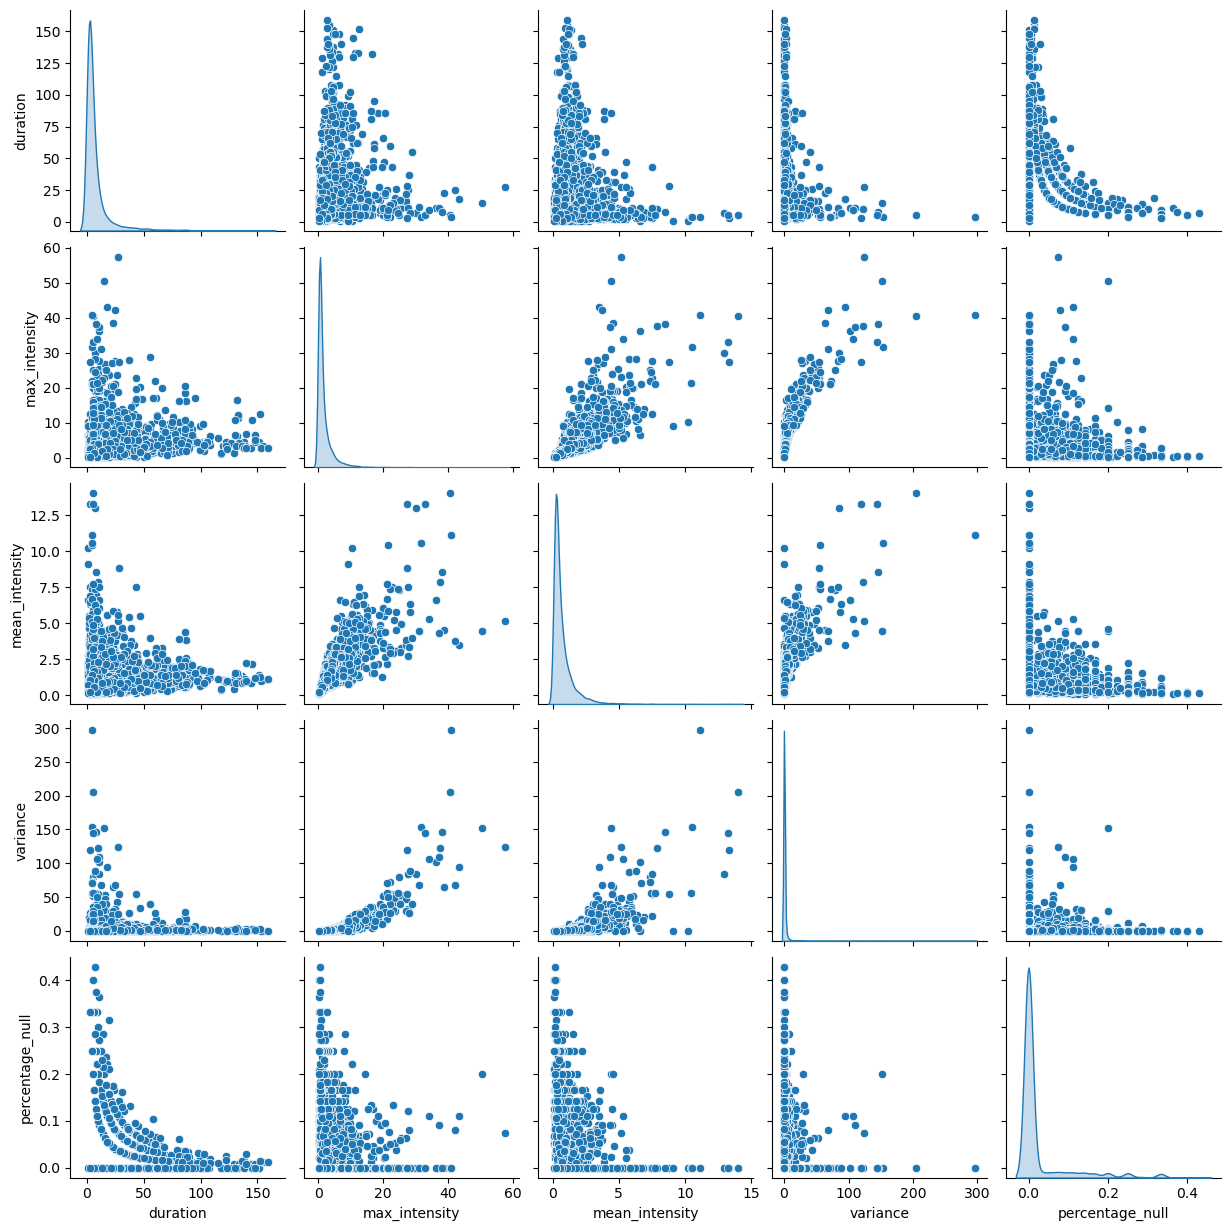

In [21]:
df_sample = df.sample(10000)[['duration', 'max_intensity', 'mean_intensity', 'variance', 'percentage_null']] # only keep features of interest
sns.pairplot(df_sample, diag_kind="kde")


# Clustering

## K-Means

In [4]:
N_CLUSTERS = 3

X = df[['duration','max_intensity', 'mean_intensity', 'variance', 'percentage_null']] # features of interest

scaler = StandardScaler()
kmeans = KMeans(n_clusters=N_CLUSTERS)
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(X)

labels = pipeline.predict(X)

df['label'] = labels

In [20]:
features = ['duration', 'max_intensity', 'mean_intensity', 'variance', 'percentage_null']

df_sample = df.sample(5000)

In [37]:
# show how much ram the dataframe is using
print(f'RAM usage: {df.memory_usage(deep=True).sum() / 1e6} MB')

RAM usage: 1673.383824 MB


In [35]:
df_sample

,month,day,i,j,start_time_relative,start_time_absolute,duration,max_intensity,mean_intensity,variance,percentage_null,label,end_time_absolute
year,,,,,,,,,,,,,
2018.0,1.0,18.0,16.0,17.0,282.0,5178.0,1.0,0.72,0.720000,0.000000,0.000000,0.0,5179.0
2018.0,1.0,26.0,117.0,81.0,211.0,7411.0,1.0,0.24,0.240000,0.000000,0.000000,0.0,7412.0
2018.0,1.0,25.0,182.0,113.0,66.0,6978.0,9.0,1.20,0.653333,0.093156,0.000000,0.0,6987.0
2018.0,1.0,19.0,57.0,78.0,149.0,5333.0,3.0,2.16,0.840000,0.892800,0.333333,2.0,5336.0
2018.0,1.0,3.0,266.0,229.0,37.0,613.0,13.0,1.44,0.406154,0.098670,0.076923,0.0,626.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018.0,1.0,21.0,251.0,271.0,185.0,5945.0,1.0,0.60,0.600000,0.000000,0.000000,0.0,5946.0
2018.0,1.0,31.0,66.0,39.0,91.0,8731.0,1.0,0.36,0.360000,0.000000,0.000000,0.0,8732.0
2018.0,1.0,2.0,164.0,295.0,99.0,387.0,7.0,0.24,0.171429,0.003527,0.000000,0.0,394.0


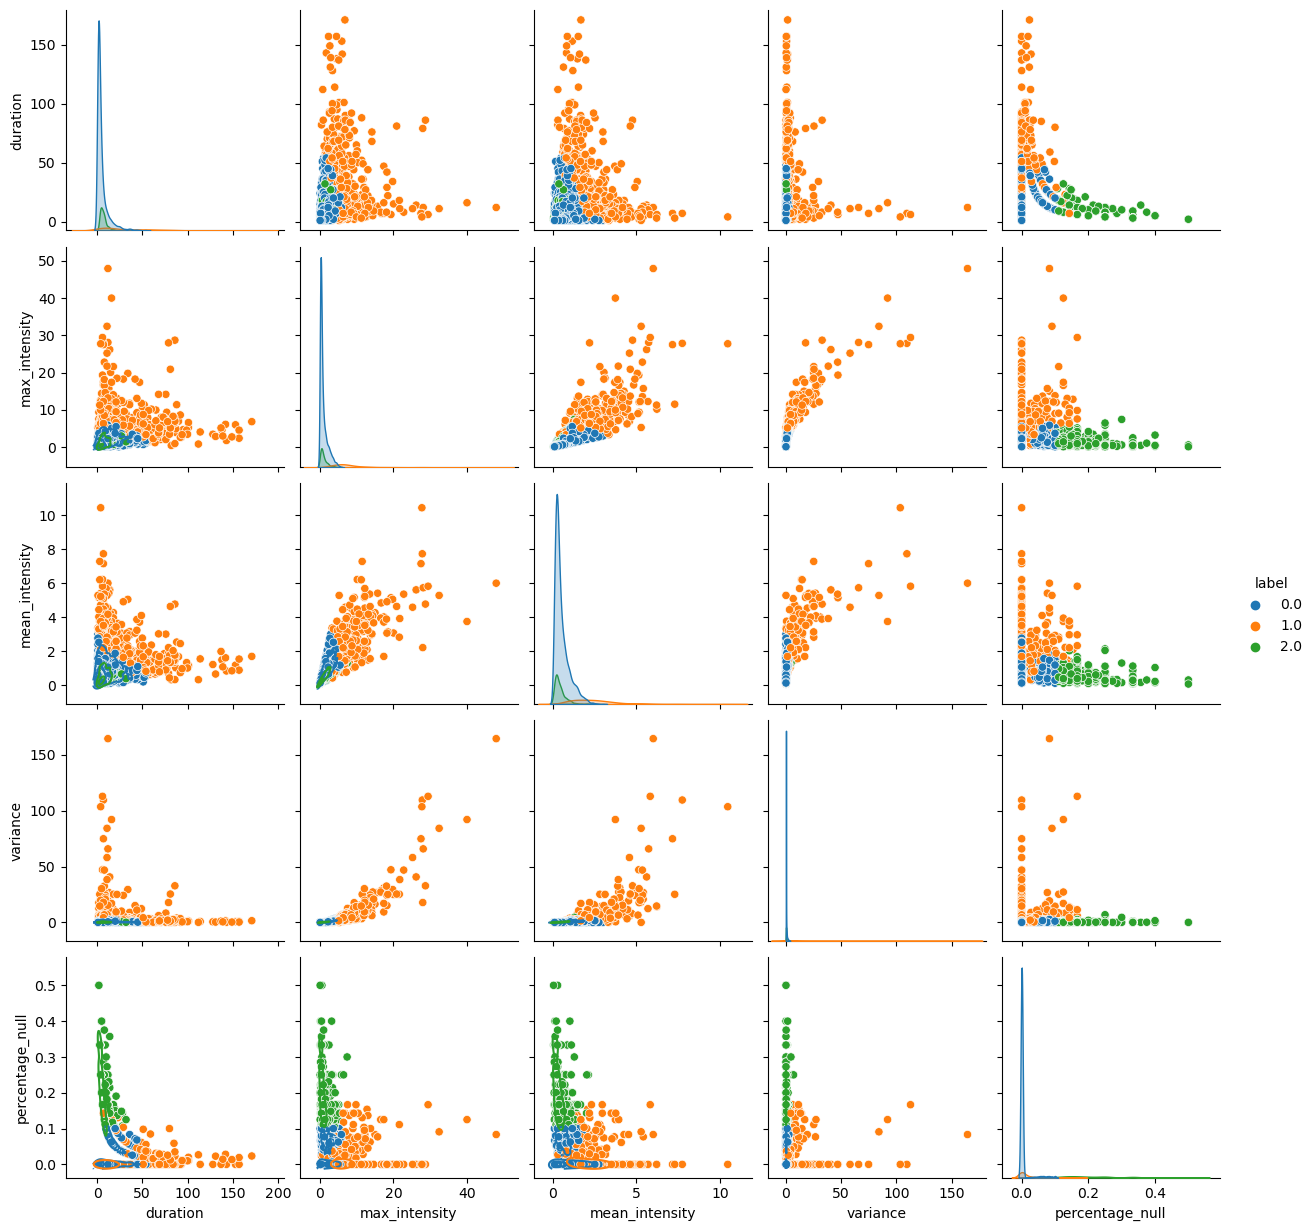

In [21]:
g = sns.pairplot(df_sample, hue="label", vars=features, palette='tab10')

Distributions

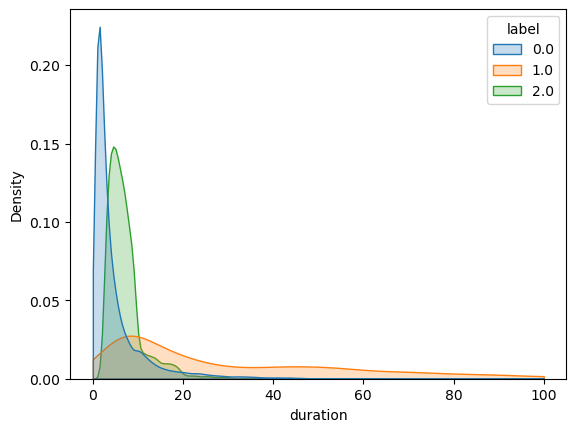

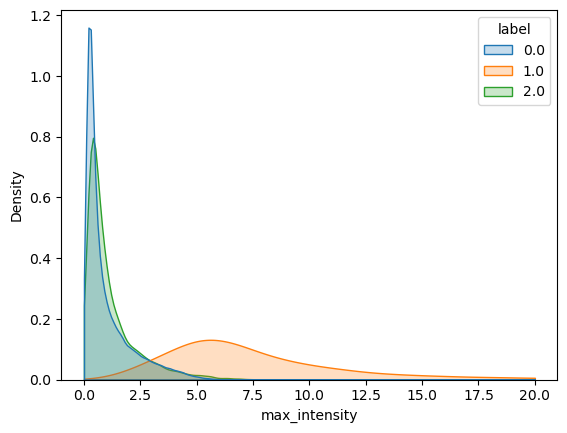

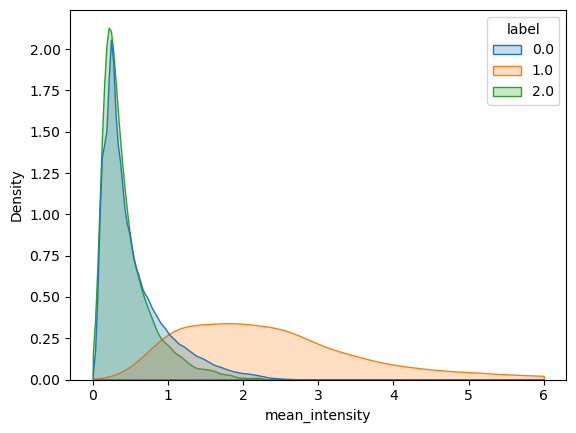

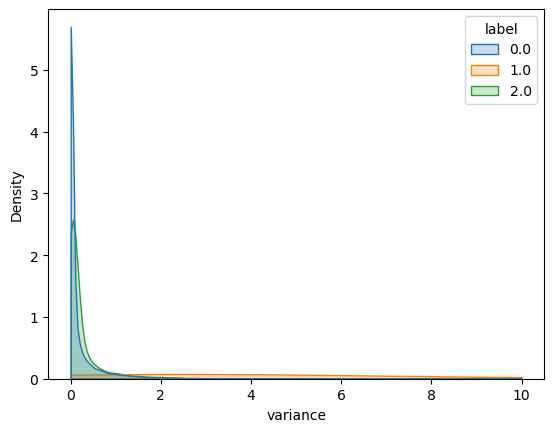

<Axes: xlabel='percentage_null', ylabel='Density'>

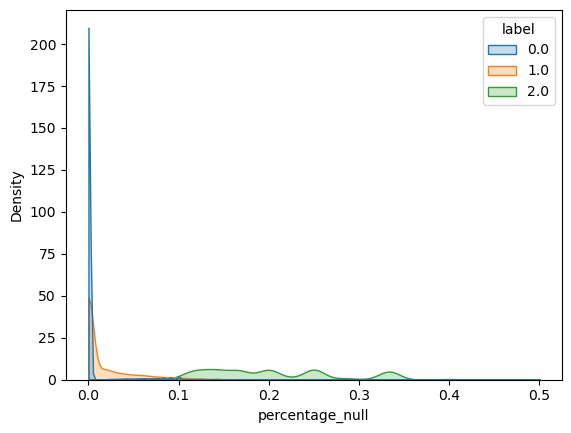

In [67]:
df_sample = df.sample(100000)

sns.kdeplot(data=df_sample, x="duration", hue='label', fill=True, common_norm=False, common_grid=True, palette='tab10', clip=(0, 100))
plt.show()
sns.kdeplot(data=df_sample, x="max_intensity", hue='label', fill=True, common_norm=False, common_grid=True, palette='tab10', clip=(0, 20))
plt.show()
sns.kdeplot(data=df_sample, x="mean_intensity", hue='label', fill=True, common_norm=False, common_grid=True, palette='tab10', clip=(0, 6))
plt.show()
sns.kdeplot(data=df_sample, x="variance", hue='label', fill=True, common_norm=False, common_grid=True, palette='tab10', clip=(0, 10))
plt.show()
sns.kdeplot(data=df_sample, x="percentage_null", hue='label', fill=True, common_norm=False, common_grid=True, palette='tab10', clip=(0, 0.5))

# Visualisation

In [23]:
# get first day of january
events_sample = df[df['day'] == 1]

In [ ]:
# creates a background image of the 300x300 grid around Paris
# don't plot anything inline

west, south, east, north = (
    0.2986403353389431,
    47.502048648648646,
    4.398959664661057,
    50.204751351351355
)

paris_img, paris_ext = cx.bounds2img(west,
                                     south,
                                     east,
                                     north,
                                     ll=True,
                                     source=cx.providers.CartoDB.Voyager
                                    )

f, ax = plt.subplots(1, figsize=(9, 9))
# remove legend
ax.get_xaxis().set_visible(False)
# remove axis scale
ax.get_yaxis().set_visible(False)
#save picture to background.png
plt.savefig('images/background.png', bbox_inches='tight', pad_inches=0)

In [33]:
# Create a scatter plot of the clustered events for each time step of the first day of January 2018
# Each frame will be saved as a PNG file, and later assembled into a GIF

length = 288
time_step = 1 # lowest
plt.figure(figsize=(10, 10))

# Create a legend manually
labels_unique = events_sample['label'].unique()
legend_elements = [mlines.Line2D([], [], marker='o', color=sns.color_palette('Set2', n_colors=N_CLUSTERS)[i], label=str(label), markersize=10, linestyle='None') for i, label in enumerate(labels_unique)]

# Create a separate legend figure
legend_fig, legend_ax = plt.subplots(figsize=(4, 2))
legend_ax.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.5), ncol=len(labels_unique))
legend_ax.axis('off')
legend_fig.savefig('images/legend.png', bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(legend_fig)

# Load the legend image
legend_img = plt.imread('images/legend.png')
# Load background image
background_img = plt.imread('images/background.png')

# Determine the extent of the data
x_min, x_max = events_sample['i'].min(), events_sample['i'].max()
y_min, y_max = events_sample['j'].min(), events_sample['j'].max()
x_padding = 0.001 * (x_max - x_min)
y_padding = 0.001 * (y_max - y_min)

legend_x_offset = 460  # Adjust this based on your figure's layout
legend_y_offset = 660  # Adjust this based on your figure's layout

# Animate the scatter plot and save each frame as a PNG
for t in range(0, length, time_step):
    currents_events = events_sample[(events_sample['start_time_absolute'] <= t) & (t <= events_sample['end_time_absolute'])]
    plt.figure(figsize=(10, 10))  # Moved inside the loop to ensure clean slate
    plt.gca().set_aspect('equal')
    sns.scatterplot(data=currents_events, x='i', y='j', hue='label', alpha=0.8, s=3, palette=sns.color_palette('Set2', n_colors=N_CLUSTERS), legend=False)
    
    # Set the x and y limits based on the extent of the data
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

    # Overlay the background image correctly
    plt.imshow(background_img, aspect='equal', extent=[x_min - x_padding, x_max + x_padding, y_min - y_padding, y_max + y_padding], zorder=0)

    # Overlay the legend image; adjust coordinates as necessary
    fig = plt.gcf()
    # Note: Adjust coordinates as necessary to place the legend correctly
    fig.figimage(legend_img, xo=legend_x_offset, yo=legend_y_offset, zorder=9, alpha=1)  # Change xo, yo values based on your layout

    # Remove the tickers
    plt.xticks([])
    plt.yticks([])
    
    # Remove the axis
    plt.axis('off')
    
    plt.savefig(f'images/kmeans_{t}.png', bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to free up memory and start fresh for the next frame

<Figure size 1000x1000 with 0 Axes>

In [34]:
# Combine into a GIF
# create a list of all the files in the directory

files = os.listdir('images')
files = [file for file in files if re.search(r'kmeans_\d+.png', file)]
files.sort(key=lambda x: int(re.search(r'kmeans_(\d+).png', x).group(1)))

# create a list of images, without imageio
images = []
for file in files:
    images.append(imageio.imread("images/"+file))

# save the gif
imageio.mimsave('kmeans_3_map.gif', images, duration=0.5, loop=0)

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_22152\2902912560.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("images/"+file))


In [ ]:
# Plot the raw data of the first day of January 2018 over the background image of Paris

first_day = get_matrix(2018, 1, 1)

length = first_day.shape[0]  # Adjusted to match the first_day shape
time_step = 1 # lowest
plt.figure(figsize=(10, 10))
# Determine the extent of the data
x_min, x_max = 0, first_day.shape[1]  # Adjusted to match the first_day shape
y_min, y_max = 0, first_day.shape[2]  # Adjusted to match the first_day shape
x_padding = 0.001 * (x_max - x_min)
y_padding = 0.001 * (y_max - y_min)

# Animate the scatter plot and save each frame as a PNG
for t in range(0, length, time_step):
    map = first_day[t].T  # Adjusted to match the first_day data
    plt.figure(figsize=(10, 10))  # Moved inside the loop to ensure clean slate
    plt.gca().set_aspect('equal')
    
    # Create a masked array where the mask is True for all "0" values
    map[map == 0] = np.nan
    
    sns.heatmap(map, cmap='viridis', alpha=0.6, cbar=False)  # Adjusted to use heatmap for matrix data
    
    # Set the x and y limits based on the extent of the data
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

    # Overlay the background image correctly
    plt.imshow(background_img, aspect='equal', extent=[x_min - x_padding, x_max + x_padding, y_min - y_padding, y_max + y_padding], zorder=0)
    
    # Remove the tickers
    plt.xticks([])
    plt.yticks([])
    
    plt.savefig(f'tmp/first_day_{t}.png', bbox_inches='tight', pad_inches=0, dpi=100)
    plt.close()  # Close the figure to free up memory and start fresh for the next frame

In [ ]:
# Combine into a GIF

files = os.listdir('tmp')
files = [file for file in files if re.search(r'first_day_\d+.png', file)]
files.sort(key=lambda x: int(re.search(r'first_day_(\d+).png', x).group(1)))

# create a list of images, without imageio
images = []
for file in files:
    images.append(imageio.imread("tmp/"+file))

# save the gif
imageio.mimsave('firstday_raw.gif', images, duration=0.5, loop=0)